In [10]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

In [5]:
#img = cv2.imread('test_intersection.png')
img = cv2.imread('../images/intersection2.png')
#img = cv2.imread('test3.png')
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

#hsv = cv2.GaussianBlur(hsv, (51, 51), 0)

lower_bound = np.array([0, 0, 50]) # H=0, S=0, V=50
upper_bound = np.array([180, 50, 150])

# Create a mask based on this range
mask = cv2.inRange(hsv, lower_bound, upper_bound)

#sobel_horizontal = cv2.Sobel(img, cv2.CV_64F, dx=0, dy=1, ksize=3)
#sobel_horizontal = cv2.convertScaleAbs(sobel_horizontal)

masked_img = cv2.bitwise_and(img, img, mask=mask)

masked_img = cv2.GaussianBlur(masked_img, (15, 15), 0)

edges = cv2.Canny(masked_img, 50, 150, apertureSize=3)

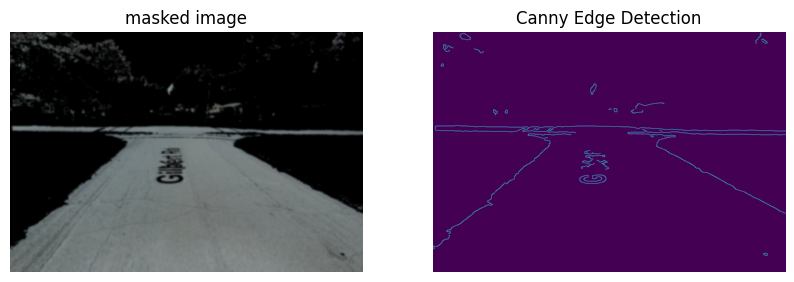

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(masked_img)
ax[0].set_title("masked image")
ax[0].axis("off")

ax[1].imshow(edges)
ax[1].set_title("Canny Edge Detection")
ax[1].axis("off")

plt.show()
plt.close()

In [7]:
lines = cv2.HoughLinesP(
    edges, 
    rho=1,         # distance resolution in pixels
    theta=np.pi/180, # angle resolution in radians
    threshold=50,  # minimum number of votes (intersections in accumulator)
    minLineLength=50,  # minimum length of a line in pixels
    maxLineGap=10    # maximum gap between segments to consider them the same line
)

print(len(lines))
#print(lines)

17


207 324 | 308 325
134 338 | 270 341
1047 541 | 1097 567
952 349 | 1070 349
939 337 | 1001 336
1093 336 | 1156 337
11 321 | 73 321
151 323 | 206 324
502 321 | 601 322
773 396 | 885 456
1002 335 | 1054 335
703 327 | 776 331
1097 566 | 1192 616
820 420 | 876 450
435 324 | 501 321
1052 543 | 1102 569
927 478 | 980 505


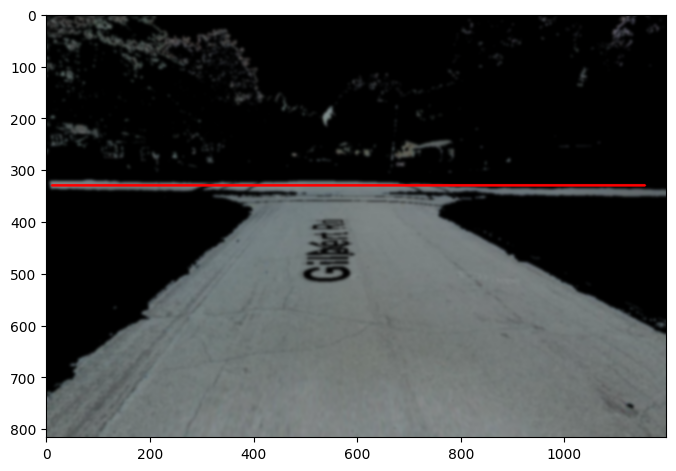

In [ ]:
line_img = masked_img.copy()

tot_y = 0
vals = 0
max_x = -math.inf
min_x = math.inf

for (x1, y1, x2, y2) in np.squeeze(lines):
    # keep only horizontalish lines
    if (abs(math.atan((y2 - y1) / (x2 - x1))) < 0.1):

        # get approx regression through the horizontal lines
        tot_y += y2
        tot_y += y1
        vals += 2
        max_x = max(max_x, x1, x2)
        min_x = min(min_x, x1, x2)

cv2.line(line_img, (min_x, tot_y // vals), (max_x, tot_y // vals), (255, 0, 0), 3)

'''
cv2.imshow("Detected Horizontal Lines", line_img)
cv2.waitKey(0)
cv2.destroyAllWindows()
'''

plt.figure(figsize=(8, 6))
plt.imshow(line_img)
plt.show()